In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline

In [43]:
raw_df=pd.read_csv('../input/zomato-restaurants-data/zomato.csv',encoding = "ISO-8859-1", engine='python')
country=pd.read_excel('../input/zomato-restaurants-data/Country-Code.xlsx')

In [44]:
df=pd.merge(raw_df,country,on='Country Code',how='left')

In [45]:
df.head(2)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes,Country
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314,Phillipines
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,1200,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591,Phillipines


## EDA

In [46]:
## Check the statistical measurements of numerical columns
df.describe()

,Restaurant ID,Country Code,Longitude,Latitude,Average Cost for two,Price range,Aggregate rating,Votes
count,9.551000e+03,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,9.051128e+06,18.365616,64.126574,25.854381,1199.210763,1.804837,2.666370,156.909748
std,8.791521e+06,56.750546,41.467058,11.007935,16121.183073,0.905609,1.516378,430.169145
min,5.300000e+01,1.000000,-157.948486,-41.330428,0.000000,1.000000,0.000000,0.000000
25%,3.019625e+05,1.000000,77.081343,28.478713,250.000000,1.000000,2.500000,5.000000
50%,6.004089e+06,1.000000,77.191964,28.570469,400.000000,2.000000,3.200000,31.000000
75%,1.835229e+07,1.000000,77.282006,28.642758,700.000000,2.000000,3.700000,131.000000
max,1.850065e+07,216.000000,174.832089,55.976980,800000.000000,4.000000,4.900000,10934.000000


1. Max value of  Average Cost for two is 80000 which is possible because the data has values in different currencies.
2. The variance in  lat and long is low for 75% of the data signifying that most of the restaurants are in one location. The country code which has ~75% of the values is 1 which is most probably India.


In [47]:
## Check the number of rows, type of columns and if there is any null value in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9551 entries, 0 to 9550
Data columns (total 22 columns):
Restaurant ID           9551 non-null int64
Restaurant Name         9551 non-null object
Country Code            9551 non-null int64
City                    9551 non-null object
Address                 9551 non-null object
Locality                9551 non-null object
Locality Verbose        9551 non-null object
Longitude               9551 non-null float64
Latitude                9551 non-null float64
Cuisines                9542 non-null object
Average Cost for two    9551 non-null int64
Currency                9551 non-null object
Has Table booking       9551 non-null object
Has Online delivery     9551 non-null object
Is delivering now       9551 non-null object
Switch to order menu    9551 non-null object
Price range             9551 non-null int64
Aggregate rating        9551 non-null float64
Rating color            9551 non-null object
Rating text             9551 non-null o

##### The dataset has 9551 rows and 21 columns. Only Cuisines column seems to have null values

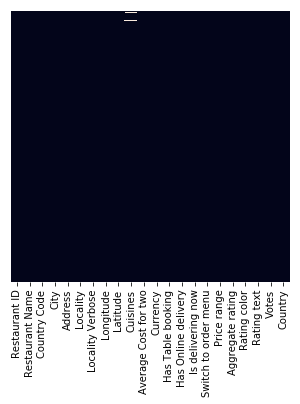

In [48]:
## Another way of finding null values and column wise density of null values
plt.figure(figsize=(5,5))
sns.heatmap(df.isnull(),cbar=False,yticklabels=False)

##### Based on the heatmap there appears to null value in the cuisines column (white bars at the top).

In [49]:
## Cuisines column deep dive
sum(df['Cuisines'].isnull()==True)

9

##### There are 9 null values in the dataset.

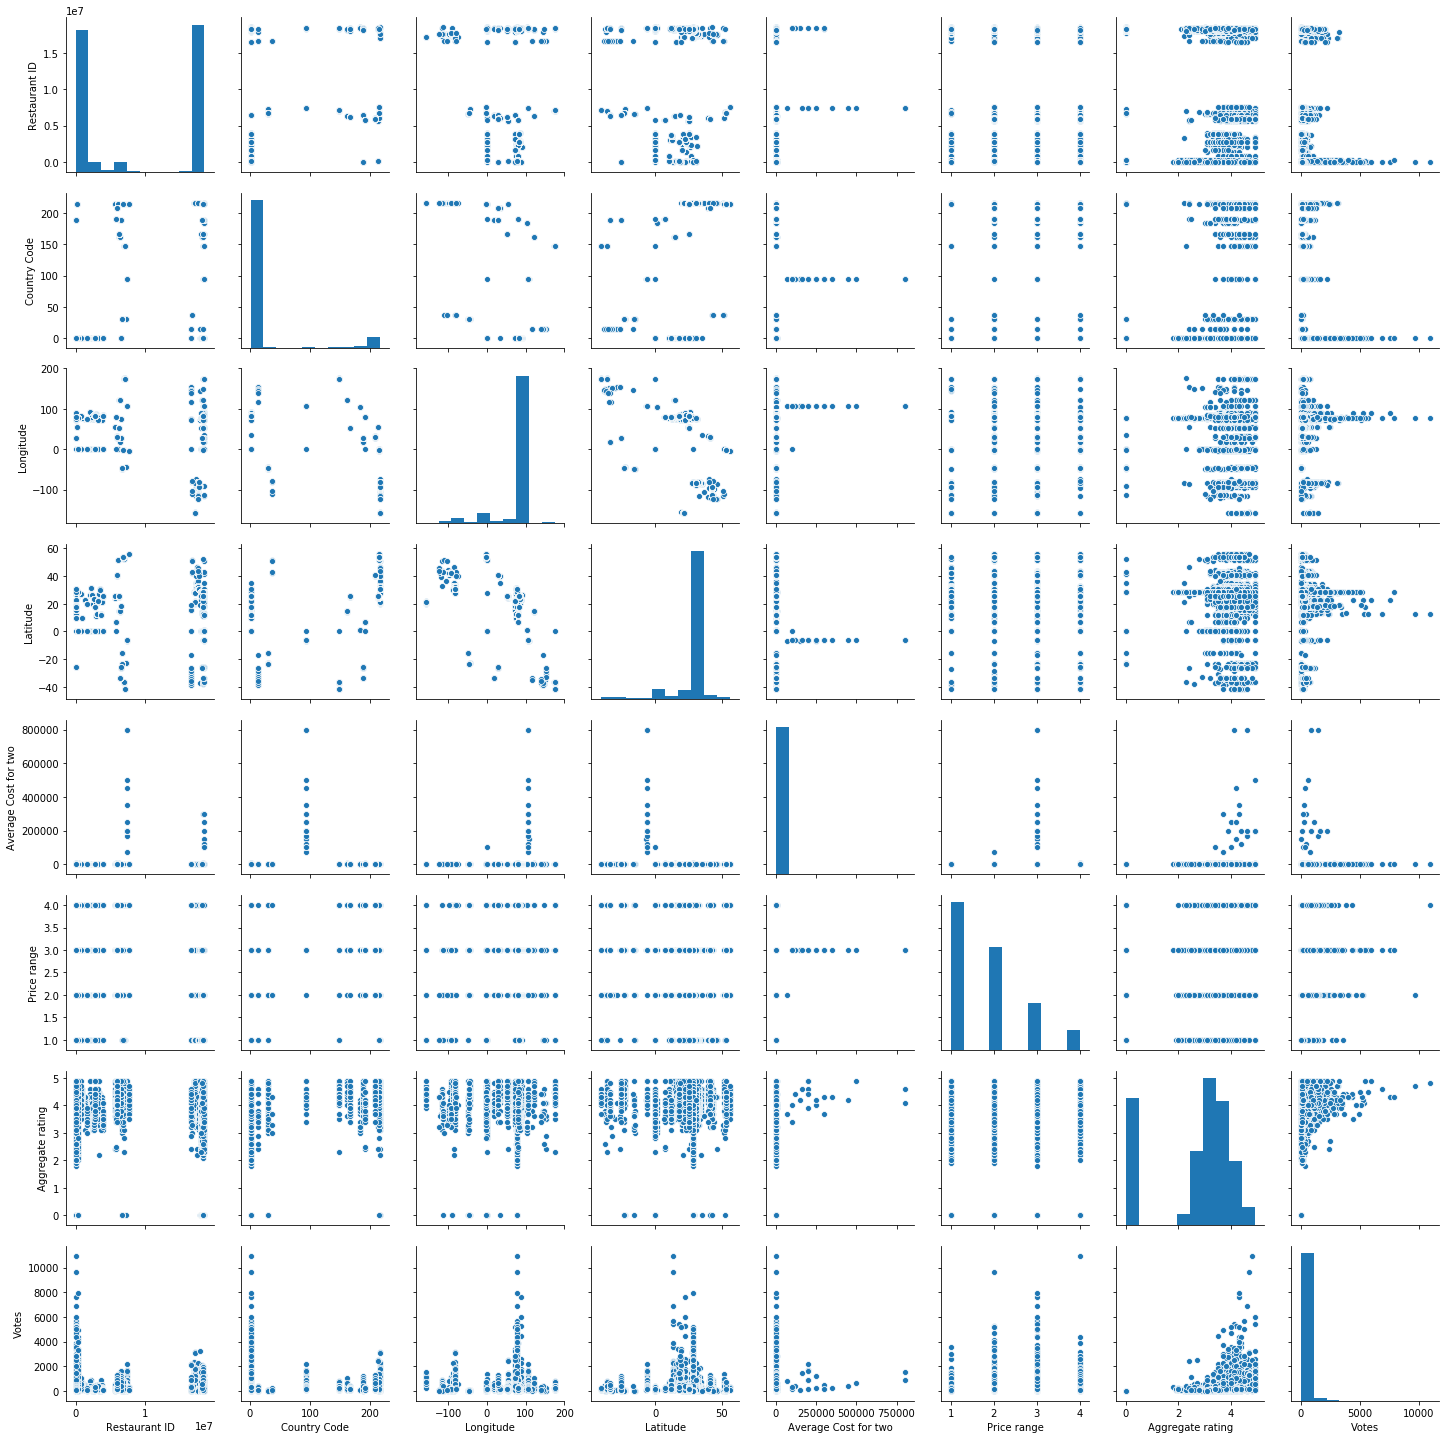

In [50]:
## pair plot to perform the univariate/bivariate analysis
sns.pairplot(df)

1. Data is sparse as it contains a lot of 0 values
2. Aggregate rating is 0 for most of the restaurants. however >0 rating distribution is similar to normal distribution.
3. Aggregate rating increases with the number of votes.
4. Price range column has only 4 discreet values

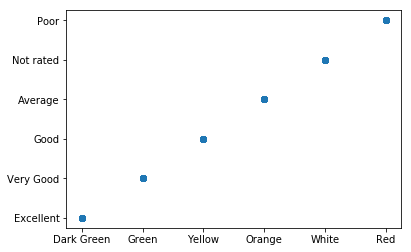

In [51]:
plt.scatter(df['Rating color'],df['Rating text'])

##### The scatter plot shows which color corresponds to which rating

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


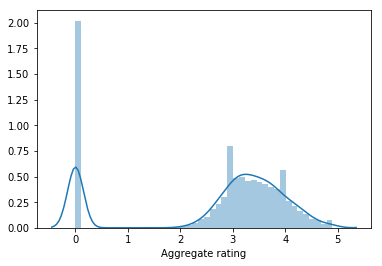

In [52]:
sns.distplot(df['Aggregate rating'])

In [53]:
import geopandas as gpd
from shapely.geometry import Point

In [54]:
india_shp=gpd.read_file('../input/world-map-shape-files/TM_WORLD_BORDERS-0.3.shp')

##### Restaurants plotting on World Map

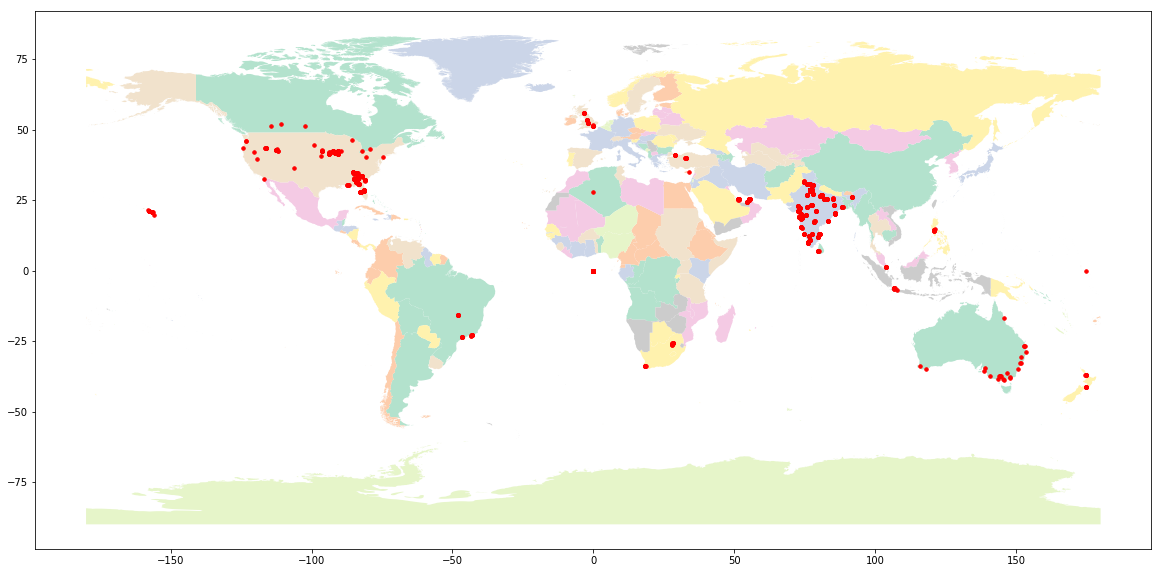

In [55]:
geometry=[Point(xy) for xy in zip(df['Longitude'],df['Latitude'])]

crs = {'init': 'epsg:27700'}

gdf=gpd.GeoDataFrame(df['Restaurant ID'],crs=crs,geometry=geometry)

fig,ax=plt.subplots(figsize=(20,10))
india_shp.plot(ax=ax,cmap='Pastel2')
gdf.plot(ax=ax,color='red',markersize=12)

##### Based on the map, few latitude nad longitude does not appear to be correct

#####  Country specific Data

In [56]:
df.groupby('Country').agg({'Restaurant ID':np.count_nonzero,\
                          'Votes':np.sum,\
                          'Aggregate rating':np.mean,\
                          'Average Cost for two':np.mean,\
                           'Currency':np.max,\
                           'Has Online delivery':np.max,\
                          }).reset_index().sort_values('Restaurant ID',ascending=False).reset_index(drop=True).rename(columns={'Restaurant ID':'No. of restaurants',\
                                                                                                                              'Votes':'Total Votes'})

,Country,No. of restaurants,Total Votes,Aggregate rating,Average Cost for two,Currency,Has Online delivery
0,India,8652,1187163,2.523324,623.370319,Indian Rupees(Rs.),Yes
1,United States,434,185848,4.004378,26.152074,Dollar($),No
2,United Kingdom,80,16439,4.087500,47.812500,Pounds(£),No
3,Brazil,60,1177,3.763333,134.666667,Brazilian Real(R$),No
4,South Africa,60,18910,4.210000,419.733333,Rand(R),No
5,UAE,60,29611,4.233333,166.416667,Emirati Diram(AED),Yes
6,New Zealand,40,9721,4.262500,69.750000,NewZealand($),No
7,Turkey,34,14670,4.300000,84.852941,Turkish Lira(TL),No
8,Australia,24,2674,3.658333,24.083333,Dollar($),No
9,Phillipines,22,8963,4.468182,1606.818182,Botswana Pula(P),No


1. Online Delivery is present in two countries: India and UAE
2. Zomato operates in a total of 15 countries

#### Top 5 Highest Rated Cuisines

In [57]:
df.groupby(['Cuisines'])['Aggregate rating'].mean().sort_values(ascending=False).head()

Cuisines
Burger, Bar Food, Steak            4.9
European, Asian, Indian            4.9
Hawaiian, Seafood                  4.9
American, Burger, Grill            4.9
Mexican, American, Healthy Food    4.9
Name: Aggregate rating, dtype: float64

* > #### Top Cuisine in each City (First 5 Examples)

In [58]:
df.groupby(['Country','City','Cuisines'])['Aggregate rating'].mean().reset_index().\
sort_values(['Country','City','Aggregate rating'],ascending=False).reset_index(drop=True).\
groupby(['Country','City']).head(1).reset_index(drop=True).head()

,Country,City,Cuisines,Aggregate rating
0,United States,Winchester Bay,"Burger, Seafood, Steak",3.2
1,United States,Weirton,"Burger, Greek, Sandwich",3.9
2,United States,Waterloo,Desserts,3.9
3,United States,Vernonia,"Coffee and Tea, Mediterranean",4.3
4,United States,Valdosta,BBQ,4.1


#### Top Restaurant in each city (First 5 examples)

In [59]:
df.groupby(['Country','City','Restaurant Name'])['Aggregate rating'].mean().reset_index().sort_values(['Country','City','Aggregate rating'],ascending=False).reset_index(drop=True).\
groupby(['Country','City']).head(1).reset_index(drop=True).head()

,Country,City,Restaurant Name,Aggregate rating
0,United States,Winchester Bay,Fishpatrick's Crabby Cafe,3.2
1,United States,Weirton,Theo Yianni's Authentic Greek Restaurant,3.9
2,United States,Waterloo,Four Queens Dairy Cream,3.9
3,United States,Vernonia,Blue House Cafe,4.3
4,United States,Valdosta,Smok'n Pig B-B-Q,4.1


#### Top 10 Restaurants with maximum branches on Zomato

In [60]:
df.groupby('Restaurant Name')['Restaurant Name'].count().sort_values(ascending=False).head(10)

Restaurant Name
Cafe Coffee Day     83
Domino's Pizza      79
Subway              63
Green Chick Chop    51
McDonald's          48
Keventers           34
Pizza Hut           30
Giani               29
Baskin Robbins      28
Barbeque Nation     26
Name: Restaurant Name, dtype: int64

In [61]:
expanded_df=df.groupby(['Currency','Price range'])['Average Cost for two'].mean().reset_index()
expanded_df['Average Cost for two']=expanded_df['Average Cost for two'].apply(lambda x: np.round(x,0))
expanded_df.pivot(index='Currency',columns='Price range',values='Average Cost for two').fillna(0)

Price range,1,2,3,4
Currency,,,,
Botswana Pula(P),0.0,600.0,954.0,2589.0
Brazilian Real(R$),30.0,49.0,75.0,185.0
Dollar($),9.0,25.0,39.0,120.0
Emirati Diram(AED),0.0,63.0,138.0,246.0
Indian Rupees(Rs.),284.0,620.0,1258.0,2583.0
Indonesian Rupiah(IDR),0.0,70000.0,291750.0,0.0
NewZealand($),23.0,39.0,54.0,103.0
Pounds(£),14.0,26.0,44.0,101.0
Qatari Rial(QR),0.0,50.0,86.0,285.0


The table shows the average cost for two at different price ranges for different currencies. There is a positive correlation between average cost for two and price range. We can also see Dollar and Pound as the strongest currencies and Indonesian Rupiah to be the weakest.

* ## Top 10 Most popular restaurants (Max no of Votes) **

<Figure size 1440x720 with 0 Axes>

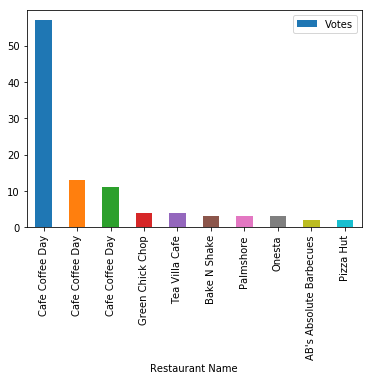

In [62]:
plt.figure(figsize=(20,10))
df.groupby(['Country','City','Restaurant Name'])['Votes'].count().reset_index().\
sort_values(['Country','City','Votes'],ascending=False).groupby(['Country','City']).head(1).\
sort_values('Votes',ascending=False).reset_index(drop=True).head(10).plot('Restaurant Name','Votes',kind='bar')

## Top 10 most popular cities (Max number of votes)
1. The metric can be used as a proxy to sort the cities by popularity on Zomato platform

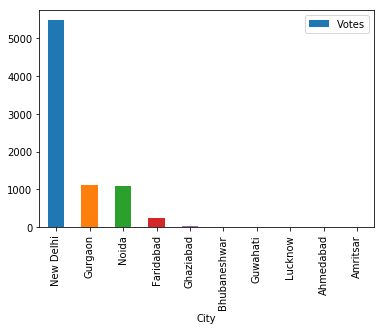

In [63]:
df.groupby(['Country','City'])['Votes'].count().reset_index().sort_values('Votes',ascending=False).reset_index(drop=True).head(10).\
plot('City','Votes',kind='bar')

New Delhi is clearly the most popular city out of 141 city Zomato operates in.

#### %age of Restaurants with Online Delivery by City in India

In [64]:
a=pd.merge(df[(df['Country']=='India')].groupby(['City']).agg({'Restaurant ID':np.count_nonzero}).reset_index(),df[(df['Has Online delivery']=='Yes')&(df['Country']=='India')].groupby(['City']).agg({'Restaurant ID':np.count_nonzero}).reset_index(),on='City',how='inner')                                                    
a.rename(columns={'Restaurant ID_x':'Total_restaurants','Restaurant ID_y':'Online_restaurants'},inplace=True)
a['%age']=a['Online_restaurants']*100/a['Total_restaurants']
a['%age']=a['%age'].apply(lambda x: np.round(x,2))
a.sort_values('Online_restaurants',ascending=False).reset_index(drop=True)

,City,Total_restaurants,Online_restaurants,%age
0,New Delhi,5473,1489,27.21
1,Gurgaon,1118,425,38.01
2,Noida,1080,364,33.70
3,Faridabad,251,35,13.94
4,Chennai,20,13,65.00
5,Ahmedabad,21,11,52.38
6,Nagpur,20,10,50.00
7,Jaipur,20,10,50.00
8,Ghaziabad,25,10,40.00
9,Kolkata,20,8,40.00


> #### WordCloud for most popular Cuisines In India

In [118]:
stopwords=list(STOPWORDS)

In [122]:
word_text=WordCloud(background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1,
                    relative_scaling=0.5,
                   height=250,
                   width=300).generate(str(df[df['Country Code']==1]['Cuisines']))

(-0.5, 1499.5, 1249.5, -0.5)

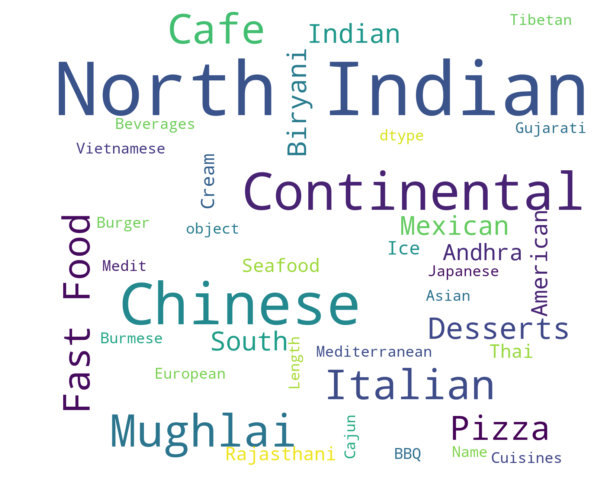

In [123]:
plt.figure(figsize=(10,10))
plt.imshow(word_text,interpolation='bilinear')
plt.axis("off")

#### WordCloud for most popular Restaurants in India

In [125]:
word_res=WordCloud(stopwords=stopwords,
                  height=250,
                  width=250,
                  random_state=2,
                  background_color='white',
                  max_words=200,
                  max_font_size=40, 
                   relative_scaling=0.5,
                  scale=5).generate(str(df[df['Country Code']==1]['Restaurant Name']))

(-0.5, 1249.5, 1249.5, -0.5)

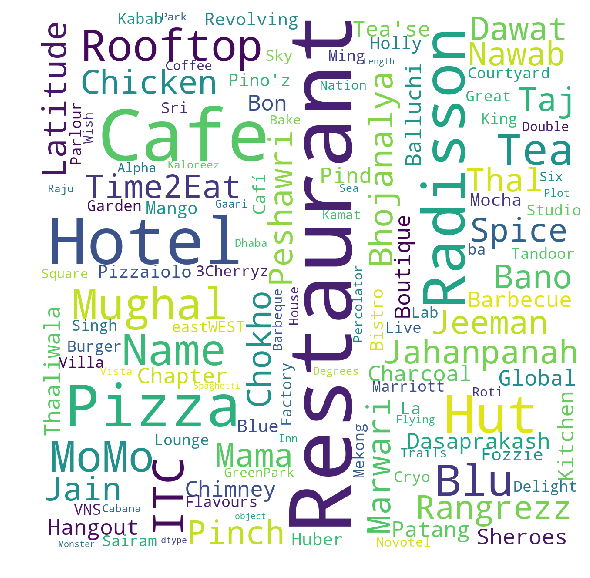

In [126]:
plt.figure(figsize=(10,10))
plt.imshow(word_res)
plt.axis('off')